# A1: A Linear Bandit Approach to Movie Recommendation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Data preprocessing

In [ ]:
# Load data sets
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

## Movie features matrix

In [ ]:
# Create matrix for movies' features
# Genres
genres = movies.genres.str.split("|", expand = True,)
genres_list = np.unique([g for g in genres.values.flatten() if g != None])
genres = pd.get_dummies(genres)
movies_features = movies.copy()

for genre in genres_list:
  movies_features[genre] = genres[[col for col in genres.columns if col.endswith(genre)]].sum(axis = 1)

movies_features = movies_features.drop(["genres", "(no genres listed)", "title"], axis = 1).set_index("movieId")
movies_features.insert(0, "Const", 1)

# Dates
titles = [title.replace(" ", "") for title in movies.title]
dates = [title[-5:-1] for title in titles]

for i in range(len(dates)):
  try: 
    dates[i] = int(dates[i])
    if dates[i] < 1874: 
      dates[i] = np.nan
  except: 
    dates[i] = np.nan

for i in range(len(dates)):
  if np.isnan(dates[i]):
    dates[i] = round(np.nanmean(dates))

movies_features["Date"] = dates
movies_features.head()

,Const,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Date
movieId,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
2,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
4,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1995
5,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995


In [ ]:
# Store data set
movies_features.to_csv("movies_features.csv")

## Ratings matrix 

In [ ]:
# Create rating matrix R
# Keep only users that saw the n_movies most seen movies
n_movies = 2000
ratings_filt = ratings[ratings.movieId.isin(movies_features.index)]
movie_ids = ratings_filt.groupby(["movieId"]).count().sort_values(by = "userId", ascending = False).index[:n_movies]
ratings_filt = ratings_filt[ratings_filt.movieId.isin(movie_ids)]

# Keep only users that rated at least 50 movies
n_ratings = 50
user_ids = ratings_filt.groupby(["userId"]).count().query("movieId >= " + str(n_ratings)).index
ratings_filt = ratings_filt[ratings_filt.userId.isin(user_ids)]

# Matrix R
R = ratings_filt.pivot(index = "userId", columns = "movieId", values = "rating")
R = R.sample(frac = 1, axis = 0)
R = R.sample(frac = 1, axis = 1)
R

movieId,72378,5014,2505,2403,122882,98961,170,51086,3257,849,...,5299,33615,2313,674,1047,112175,3861,119141,1997,7387
userId,,,,,,,,,,,,,,,,,,,,,
48892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
100296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112599,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Store data set
R.to_csv("R.csv")

In [ ]:
# Delete useless variables
del movies, ratings

## User features

In [ ]:
# Compute users features
def users_features_function(R, movies_features, lambd):
  df = pd.DataFrame(index = R.index, columns = range(movies_features.shape[1]))

  for i in tqdm(range(R.shape[0])):
    movie_ids = R.iloc[i,:].dropna().index
    y = R.iloc[i,:].dropna().values.reshape(-1,1)
    X = movies_features.loc[movie_ids,:].values    
    reg = Ridge(fit_intercept = False, alpha = lambd).fit(X,y)
    df.iloc[i,:] = reg.coef_

  df.insert(0, "Const", 1)
  return df

### Training/test matrices

In [ ]:
# Divide R into training/test samples
train_size = .5
train_map = pd.DataFrame(np.random.binomial(1, train_size, R.shape), index = R.index, columns = R.columns)
test_map = 1-train_map
R_train, R_test = R*train_map.replace(0,np.nan), R*test_map.replace(0,np.nan)

In [ ]:
# Store data sets
R_train.to_csv("R_train.csv")
R_test.to_csv("R_test.csv")

In [ ]:
# Delete useless variables
del R, R_test

### Full number of features

In [ ]:
# Create matrix of users features
users_features = users_features_function(R_train, movies_features, lambd = 1)

100%|██████████| 95023/95023 [23:22<00:00, 67.75it/s]


In [ ]:
# Store data set
users_features.to_csv("users_features.csv")

### Reduced number of features

#### PCA

In [ ]:
# Reduce the number of movies's features using PCA
sc = StandardScaler()
movies_features_sc = sc.fit_transform(movies_features.loc[R_train.columns,:].values)
n_components = 5
pca = PCA(n_components = n_components)
m_features_pca = pd.DataFrame(pca.fit_transform(movies_features_sc), index = R_train.columns, columns = range(n_components))
m_features_pca.insert(0, "Const", 1)

In [ ]:
# Compute new users features
u_features_pca = users_features_function(R_train, m_features_pca, lambd = 1)

100%|██████████| 95023/95023 [01:49<00:00, 866.11it/s]


In [ ]:
# Store data sets
m_features_pca.to_csv("m_features_pca.csv")
u_features_pca.to_csv("u_features_pca.csv")

#### K-means

In [ ]:
# Reduce the number of movies's features using KMeans clustering
sc = MinMaxScaler()
movies_features_sc = movies_features.loc[R_train.columns,:]
movies_features_sc.iloc[:,[-1]] = sc.fit_transform(movies_features_sc.values[:,[-1]])
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(movies_features_sc.values[:,1:])

# Define new matrix of movies' features with reduced dimensions
m_features_kmeans = pd.get_dummies(pd.DataFrame(kmeans.labels_, index = movies_features_sc.index).astype(str))
m_features_kmeans.columns = range(n_clusters)
m_features_kmeans.insert(0, "Const", 1)

In [ ]:
# Compute new users features
u_features_kmeans = users_features_function(R_train, m_features_kmeans, lambd = 1)

100%|██████████| 95023/95023 [01:50<00:00, 862.79it/s]


In [ ]:
# Store data sets
m_features_kmeans.to_csv("m_features_kmeans.csv")
u_features_kmeans.to_csv("u_features_kmeans.csv")

# Algorithms implementation

## Random recommendations

In [ ]:
# Import relevant data set
R = pd.read_csv("R.csv", index_col = 0)
R.columns = R.columns.astype(int)

In [ ]:
# Recommend movies randomly
def random_recommendation(R):
  n_users = R.shape[0]
  regrets = []
  
  for user in tqdm(range(n_users)):
    rated_movies = 1-np.isnan(R.values[user,:])*1    
    possible_arms = np.where(rated_movies == 1)[0]
    chosen_arm = choice(possible_arms)
    reward = R.values[user, chosen_arm]
    regrets.append(np.nanmax(R.values[user,:]) - reward)

  return regrets

In [ ]:
regrets_rr = random_recommendation(R)
np.save("regrets_rr.npy", regrets_rr)

100%|██████████| 95023/95023 [00:06<00:00, 15288.94it/s]


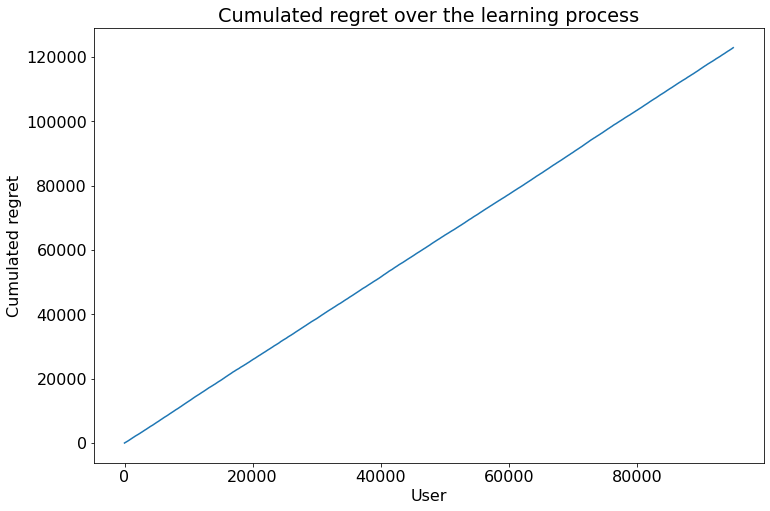

In [ ]:
# Plot cumulated regret
plt.figure(figsize = (12,8))
plt.plot(np.cumsum(regrets_rr))
plt.title("Cumulated regret over the learning process")
plt.xlabel("User")
plt.ylabel("Cumulated regret")
plt.show()

## Context-free K-bandit algorithm

In [ ]:
# Implement context-free KB
def context_free_k_armed_bandit(R, alpha):
  n_users, n_arms = R.shape
  n_selections = np.array([0]*n_arms)
  sums_of_ratings = np.array([0.]*n_arms)
  avg_ratings = np.array([0.]*n_arms)
  upper_bounds = np.array([np.inf]*n_arms)
  regrets = []

  for user in tqdm(range(n_users)):
    rated_movies = 1-np.isnan(R.values[user,:])*1    
    possible_arms = np.where(rated_movies == 1)[0]
    chosen_arm = possible_arms[np.argmax(upper_bounds[possible_arms])]
    n_selections[chosen_arm] += 1
    sums_of_ratings[chosen_arm] += R.values[user, chosen_arm]
    avg_ratings[chosen_arm] = sums_of_ratings[chosen_arm]/n_selections[chosen_arm]
    upper_bounds[chosen_arm] = avg_ratings[chosen_arm] + alpha*1/np.sqrt(n_selections[chosen_arm])
    reward = R.values[user, chosen_arm]
    regrets.append(np.nanmax(R.values[user,:]) - reward)

  return regrets

In [ ]:
regrets_cfkb = context_free_k_armed_bandit(R, alpha = 2)
np.save("regrets_cfkb.npy", regrets_cfkb)

100%|██████████| 95023/95023 [00:06<00:00, 14401.87it/s]


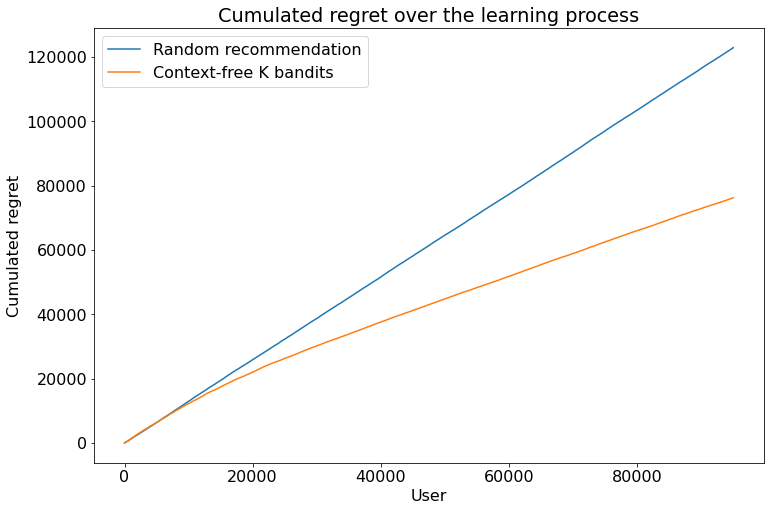

In [ ]:
# Plot cumulated regrets
plt.figure(figsize = (12,8))
plt.plot(np.cumsum(regrets_rr), label = "Random recommendation")
plt.plot(np.cumsum(regrets_cfkb), label = "Context-free K bandits")
plt.title("Cumulated regret over the learning process")
plt.xlabel("User")
plt.ylabel("Cumulated regret")
plt.legend()
plt.show()

## Context-free linear-bandit algorithm

In [ ]:
# Import relevant data set
movies_features = pd.read_csv("movies_features.csv", index_col = 0)

In [ ]:
# Implement context-free LB
def context_free_linear_bandit(R, arms_features, alpha, lambd):
  n_users, n_arms = R.shape
  n_features = arms_features.shape[1]
  selected_arms = []
  regrets = []
  A = lambd*np.eye(n_features)
  b = np.zeros((n_features,1))

  for user in tqdm(range(n_users)):
    rated_movies = 1-np.isnan(R.values[user,:])*1    
    possible_arms = np.where(rated_movies == 1)[0]
    possible_arms_ids = np.array(R.columns[possible_arms])
    theta = np.linalg.inv(A)@b
    xt = arms_features.loc[possible_arms_ids,:].values
    expected_rewards = xt@theta
    upper_bounds = [expected_rewards[i,0] + alpha*np.sqrt((xt[[i],:]@np.linalg.inv(A)@xt[[i],:].T)[0][0]) for i in range(xt.shape[0])]
    maxub_i = np.argmax(upper_bounds)
    chosen_arm = possible_arms[maxub_i]
    chosen_arm_id = possible_arms_ids[maxub_i]
    xt_max = xt[[maxub_i],:]
    reward = R.values[user, chosen_arm]
    regrets.append(np.nanmax(R.values[user,:]) - reward)
    A += xt_max.T@xt_max
    b += reward*xt_max.T

  return regrets

In [ ]:
regrets_cflb = context_free_linear_bandit(R, arms_features = movies_features, alpha = 2, lambd = 1)
np.save("regrets_cflb.npy", regrets_cflb)

100%|██████████| 95023/95023 [14:07<00:00, 112.13it/s]


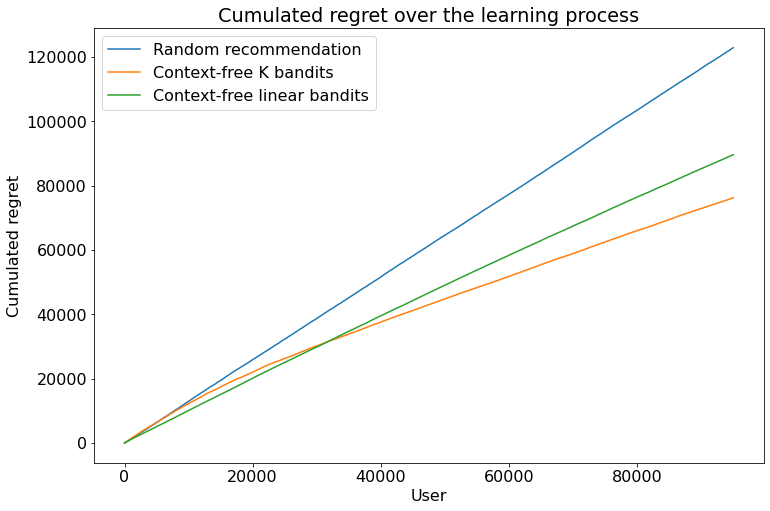

In [ ]:
# Plot cumulated regrets
plt.figure(figsize = (12,8))
plt.plot(np.cumsum(regrets_rr), label = "Random recommendation")
plt.plot(np.cumsum(regrets_cfkb), label = "Context-free K bandits")
plt.plot(np.cumsum(regrets_cflb), label = "Context-free linear bandits")
plt.title("Cumulated regret over the learning process")
plt.xlabel("User")
plt.ylabel("Cumulated regret")
plt.legend()
plt.show()

## Contextual linear-bandit algorithm

In [ ]:
# Implement contextual LB using users features
def contextual_linear_bandit(R, users_features, alpha, lambd):
  n_users, n_arms = R.shape
  n_features = users_features.shape[1]
  regrets = []
  As = [lambd*np.eye(n_features)]*n_arms
  bs = [np.zeros((n_features,1))]*n_arms

  for user in tqdm(range(n_users)):
    rated_movies = 1-np.isnan(R.values[user,:])*1    
    possible_arms = np.where(rated_movies == 1)[0]
    possible_arms_ids = np.array(R.columns[possible_arms])
    upper_bounds = []
    xt = users_features.values[[user],:].astype("float64")

    for arm in possible_arms:
      A, b = As[arm], bs[arm]
      theta = np.linalg.inv(A)@b
      upper_bounds.append(xt@theta + alpha*np.sqrt((xt@np.linalg.inv(A)@xt.T)[0][0]))

    maxub_i = np.argmax(upper_bounds)
    chosen_arm = possible_arms[maxub_i]
    reward = R.values[user, chosen_arm]
    regrets.append(np.nanmax(R.values[user,:]) - reward)
    As[chosen_arm] = As[chosen_arm] + xt.T@xt
    bs[chosen_arm] = bs[chosen_arm] + reward*xt.T

  return regrets

### Using the full number of features

In [ ]:
# Import relevant data sets
R_test = pd.read_csv("R_test.csv", index_col = 0)
R_test.columns = R_test.columns.astype(int)
users_features = pd.read_csv("users_features.csv", index_col = 0)

In [ ]:
regrets_clb = contextual_linear_bandit(R_test, users_features, alpha = 2, lambd = 1)
np.save("regrets_clb.npy", regrets_clb)

100%|██████████| 95023/95023 [16:15<00:00, 97.42it/s] 


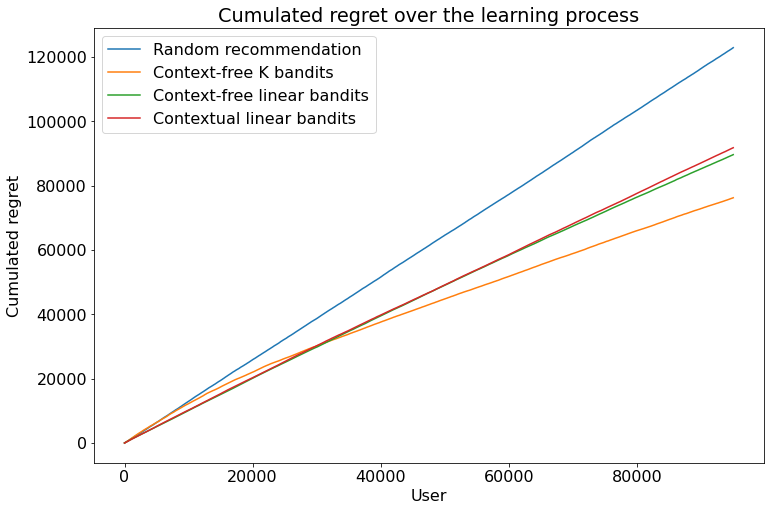

In [ ]:
# Plot cumulated regrets
plt.figure(figsize = (12,8))
plt.plot(np.cumsum(regrets_rr), label = "Random recommendation")
plt.plot(np.cumsum(regrets_cfkb), label = "Context-free K bandits")
plt.plot(np.cumsum(regrets_cflb), label = "Context-free linear bandits")
plt.plot(np.cumsum(regrets_clb), label = "Contextual linear bandits")
plt.title("Cumulated regret over the learning process")
plt.xlabel("User")
plt.ylabel("Cumulated regret")
plt.legend()
plt.show()

### Using a reduced number of features

#### PCA

In [ ]:
# Import relevant data sets
u_features_pca = pd.read_csv("u_features_pca.csv", index_col = 0)

In [ ]:
# Implement contextual LB
regrets_clb_pca = contextual_linear_bandit(R_test, u_features_pca, alpha = 2, lambd = 1)
np.save("regrets_clb_pca.npy", regrets_clb_pca)

100%|██████████| 95023/95023 [13:24<00:00, 118.19it/s]


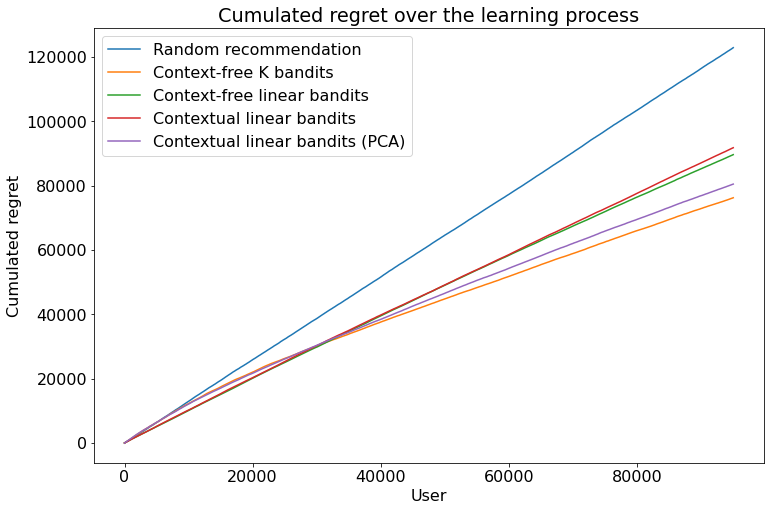

In [ ]:
# Plot cumulated regrets
plt.figure(figsize = (12,8))
plt.plot(np.cumsum(regrets_rr), label = "Random recommendation")
plt.plot(np.cumsum(regrets_cfkb), label = "Context-free K bandits")
plt.plot(np.cumsum(regrets_cflb), label = "Context-free linear bandits")
plt.plot(np.cumsum(regrets_clb), label = "Contextual linear bandits")
plt.plot(np.cumsum(regrets_clb_pca), label = "Contextual linear bandits (PCA)")
plt.title("Cumulated regret over the learning process")
plt.xlabel("User")
plt.ylabel("Cumulated regret")
plt.legend()
plt.show()

#### K-Means

In [ ]:
# Import relevant data sets
u_features_kmeans = pd.read_csv("u_features_kmeans.csv", index_col = 0)

In [ ]:
# Implement contextual LB
regrets_clb_kmeans = contextual_linear_bandit(R_test, u_features_kmeans, alpha = 2, lambd = 1)
np.save("regrets_clb_kmeans.npy", regrets_clb_kmeans)

100%|██████████| 95023/95023 [12:44<00:00, 124.36it/s]


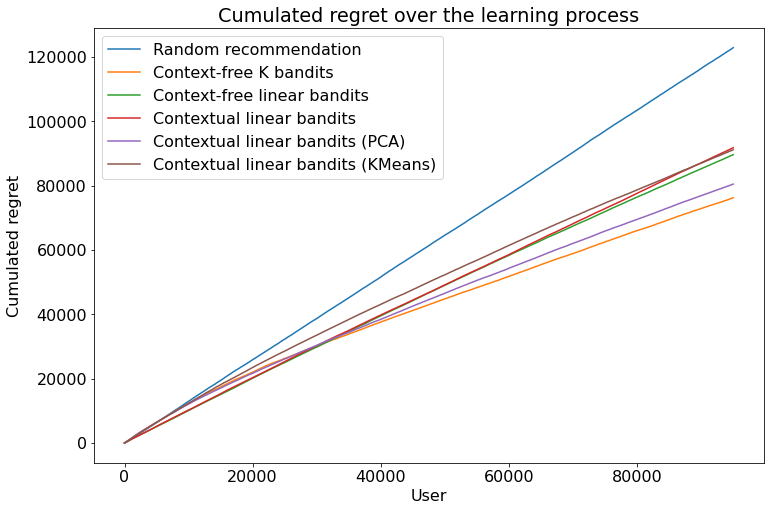

In [ ]:
# Plot cumulated regrets
plt.figure(figsize = (12,8))
plt.plot(np.cumsum(regrets_rr), label = "Random recommendation")
plt.plot(np.cumsum(regrets_cfkb), label = "Context-free K bandits")
plt.plot(np.cumsum(regrets_cflb), label = "Context-free linear bandits")
plt.plot(np.cumsum(regrets_clb), label = "Contextual linear bandits")
plt.plot(np.cumsum(regrets_clb_pca), label = "Contextual linear bandits (PCA)")
plt.plot(np.cumsum(regrets_clb_kmeans), label = "Contextual linear bandits (KMeans)")
plt.title("Cumulated regret over the learning process")
plt.xlabel("User")
plt.ylabel("Cumulated regret")
plt.legend()
plt.show()

## Contextual hybrid linear-bandit algorithm

In [ ]:
# Import relevant data set
m_features_pca = pd.read_csv("m_features_pca.csv", index_col = 0)

In [ ]:
# Implement contextual hybrid linear-bandit algorithm
def hybrid_linear_bandit(R, users_features, movies_features, alpha, lambd):
  n_users, n_arms = R.shape
  n_features_u = users_features.shape[1]
  n_features_m = movies_features.shape[1]
  regrets = []
  As = [lambd*np.eye(n_features_u)]*n_arms
  Bs = [np.zeros((n_features_u, n_features_u*n_features_m))]*n_arms
  bs = [np.zeros((n_features_u, 1))]*n_arms
  A0 = lambd*np.eye(n_features_u*n_features_m)
  b0 = np.zeros((n_features_u*n_features_m, 1))

  for user in tqdm(range(n_users)):
    rated_movies = 1-np.isnan(R.values[user,:])*1    
    possible_arms = np.where(rated_movies == 1)[0]
    possible_arms_ids = np.array(R.columns[possible_arms])
    upper_bounds = []
    zts = []
    xt = users_features.values[[user],:].astype("float64")
    beta = np.linalg.inv(A0)@b0

    for i, arm in enumerate(possible_arms):
      arm_id = possible_arms_ids[i]
      A, B, b = As[arm], Bs[arm], bs[arm]
      zt = (xt.T@movies_features.loc[[arm_id],:].values).reshape(1,-1)
      theta = np.linalg.inv(A) @ (b - B@beta)
      var = zt@np.linalg.inv(A0)@zt.T - 2*zt@np.linalg.inv(A0)@B.T@np.linalg.inv(A)@xt.T + xt@np.linalg.inv(A)@xt.T + xt@np.linalg.inv(A)@B@np.linalg.inv(A0)@B.T@np.linalg.inv(A)@xt.T
      upper_bounds.append(zt@beta + xt@theta + alpha*np.sqrt(var))
      zts.append(zt)

    maxub_i = np.argmax(upper_bounds)
    chosen_arm = possible_arms[maxub_i]
    reward = R.values[user, chosen_arm]
    regrets.append(np.nanmax(R.values[user,:]) - reward)
    A0 = A0 + Bs[chosen_arm].T@np.linalg.inv(As[chosen_arm])@Bs[chosen_arm]
    b0 = b0 + Bs[chosen_arm].T@np.linalg.inv(As[chosen_arm])@bs[chosen_arm]
    As[chosen_arm] = As[chosen_arm] + xt.T@xt
    Bs[chosen_arm] = Bs[chosen_arm] + xt.T@zts[maxub_i]
    bs[chosen_arm] = bs[chosen_arm] + reward*xt.T
    A0 = A0 + zts[maxub_i].T@zts[maxub_i] - Bs[chosen_arm].T@np.linalg.inv(As[chosen_arm])@Bs[chosen_arm]
    b0 = b0 + reward*zts[maxub_i].T - Bs[chosen_arm].T@np.linalg.inv(As[chosen_arm])@bs[chosen_arm]

  return regrets

In [ ]:
regrets_hlb = hybrid_linear_bandit(R_test, u_features_pca, m_features_pca, alpha = 2, lambd = 1)
np.save("regrets_hlb.npy", regrets_hlb)

100%|██████████| 95023/95023 [2:47:32<00:00,  9.45it/s]


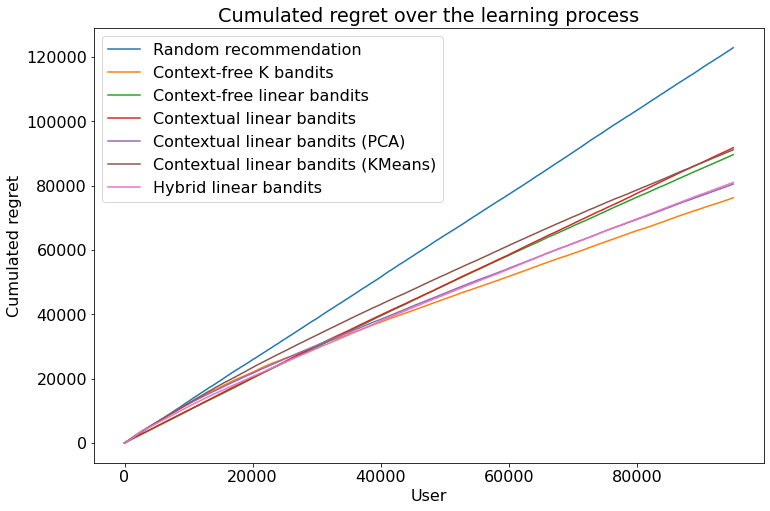

In [ ]:
# Plot cumulated regrets
plt.figure(figsize = (12,8))
plt.plot(np.cumsum(regrets_rr), label = "Random recommendation")
plt.plot(np.cumsum(regrets_cfkb), label = "Context-free K bandits")
plt.plot(np.cumsum(regrets_cflb), label = "Context-free linear bandits")
plt.plot(np.cumsum(regrets_clb), label = "Contextual linear bandits")
plt.plot(np.cumsum(regrets_clb_pca), label = "Contextual linear bandits (PCA)")
plt.plot(np.cumsum(regrets_clb_kmeans), label = "Contextual linear bandits (KMeans)")
plt.plot(np.cumsum(regrets_hlb), label = "Hybrid linear bandits")
plt.title("Cumulated regret over the learning process")
plt.xlabel("User")
plt.ylabel("Cumulated regret")
plt.legend()
plt.show()

## Linear bandits in real time

In [ ]:
# Import Data
# Import ratings
ratings = pd.read_csv('ratings.csv')
ratings.sort_values(by=['timestamp'])
del ratings['timestamp']

# Import movies
movies = pd.read_csv('movies.csv')
movies['id2'] = range(len(movies))

# Import movie features
movies_features = pd.read_csv('movies_features.csv', index_col = 0)
del movies_features["Const"]
movies_features.insert(1,'moy',[0]*len(movies_features),True)
movies_features.insert(2,'visio',[0]*len(movies_features),True)
movies_features.head()

In [ ]:
# Replace movieID by new ID
dict_map = dict(zip(movies.movieId,movies.id2))
ratings['movieId'] = ratings['movieId'].map(dict_map)
Rates = ratings.to_numpy(na_value=0) # matrix of 3 column (userID, movieID, rate) and rows are sorted by the time of the rating
print(Rates.shape)
N_user = int(np.max(Rates[:,0]))
N_movie = int(np.max(Rates[:,1]))

(100836, 3)


In [ ]:
# Define features
N_features_movie = len(movies_features.columns) # genre, epoque, note moyenne, nombre de visionnage
N_features_user = 2 # note moyenne, nombre de visionnage,  plus tard: note moyenne pour ce genre, note moyenne pour cette epoque
user_context = np.zeros((N_user,N_features_user)) # context matrix with rows as user and column are different features of the users
movie_context = movies_features.to_numpy(na_value=0) # context matrix with rows as movie and column are different features of the movie

In [ ]:
# Implement the Linear bandit algorithm with LUCB, give a vector of interest of the arms  
def LB(userID,user_context_vect,movie_context,N_movie,N_feature,dico_context,alpha=0.5):
    vector_arms = np.zeros(N_movie)

    for a in range(N_movie) :    # userID start to 1, so -1 to start to 0
        if a not in dico_context.keys():
            A = np.eye(N_feature)
            b = np.zeros(N_feature)
        else:
            (A,b)=dico_context[a]
        
        x = np.concatenate((user_context_vect,movie_context[a,:]))
        Ar = np.linalg.inv(A)
        theta = np.dot(Ar,b)
        vector_arms[a] = np.dot(theta.T,x)+alpha*np.sqrt((np.dot(x.T,np.dot(Ar,x))))

    return vector_arms

In [ ]:
# Verify if our prediction of the rate is good and update the context matrixes
def verifyLB(Rates,t,userID,vector_arms,dico_context,user_context,movie_context,N_feature):
    movieID = int(Rates[t,1]-1)
    true_rate = Rates[t,2]

    # Map the arm vector in rate vector
    possible_rate = [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]
    vector_arms = (vector_arms-np.amin(vector_arms))/np.amax(vector_arms)*5
    vector_rate = np.digitize(vector_arms,possible_rate)

    # Evaluate and give recompense
    score = 5-abs(vector_rate[movieID]-true_rate)

    # Update A and B
    x = np.concatenate((user_context[userID,:],movie_context[movieID,:]))

    if movieID not in dico_context.keys():
            A = np.eye(N_feature)
            b = np.zeros(N_feature)
    else:
        (A,b)=dico_context[movieID]

    A = A + np.dot(x,x.T)
    b = b + score*x
    dico_context[movieID] = (A,b)

    # Update context
    movie_context[movieID,2] = (movie_context[movieID,2]*movie_context[movieID,3]+true_rate)/(movie_context[movieID,3]+1) # update mean rate
    movie_context[movieID,3] = movie_context[movieID,3]+1 # update watch number
    user_context[userID,0] = (user_context[userID,0]*user_context[userID,1]+true_rate)/(user_context[userID,1]+1) # update mean rate
    user_context[userID,1] = user_context[userID,1]+1 # update watch number

    return score,dico_context,user_context,movie_context

100%|██████████| 10083/10083 [2:05:16<00:00,  1.34it/s]


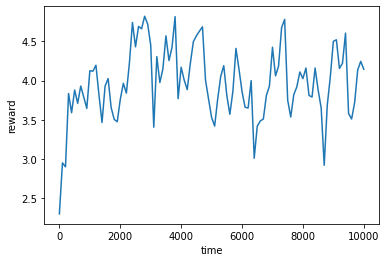

In [ ]:
# Train 
N_feature = N_features_movie+N_features_user

# Graphic interface
"""line1 = []
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot([],[],'r-o',alpha=0.8)  
plt.xlabel('time')
ax.set_ylabel('score')
plt.show()"""

sc =0 
l_sc=[0]
l_t=[0]
dico_context=dict()

for t in tqdm.tqdm(range(int(len(Rates)/10))):
    userID = int(Rates[t,0]-1) # userID start to 1, so -1 to start to 0   
    vector_arms = LB(userID,user_context[userID,:],movie_context,N_movie,N_feature,dico_context)
    score,dico_context,user_context,movie_context = verifyLB(Rates,t,userID,vector_arms,dico_context,user_context,movie_context,N_feature)
    sc+=score

    if t%100 ==0:    # print graphic
        #print(sc/10)
        l_sc.append(sc/100)
        l_t.append(t)
        sc=0

        '''line1.set_data(l_t,l_sc)

        if np.min(l_sc)<=line1.axes.get_ylim()[0] or np.max(l_sc)>=line1.axes.get_ylim()[1]:
            ax.set_ylim([0,np.max(l_sc)+np.std(l_sc)])
        if l_t[-1]>=line1.axes.get_xlim()[1]<:
            ax.set_xlim([0,l_t[-1]+50])

        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(0.01)'''

for i in range(len(l_sc)):
  l_sc[i]+=2.3

plt.figure(2)
plt.plot(l_t,l_sc)
plt.xlabel("time")
plt.ylabel('reward')
plt.show()